# Loading Library and Data

In [402]:
import pandas as pd
from matplotlib import pyplot
import seaborn as sns; sns.set_theme()
import os
import glob

def get_files(fn):
    home = os.path.expanduser('~')
    path = f'{home}/Downloads/project_mining_2022/dataset/'
    files = glob.glob(path + fn + '/*.csv')
    return files


def to_date(char):
    return char[:4] + '-' + char[4:6] + '-' + char[6:8]

# for each file create a pandas df
# concatenate them all together
# change index to datetime
def parse_file(files, filenames):
    list_of_pandas = []
    for i, f in enumerate(files):
        # if file empty
        if os.stat(f).st_size != 0:
            # create df
            temp = pd.read_csv(f, header=0, nrows=288, skip_blank_lines=False)
            # create date column
            temp['Date'] = [to_date(filenames[i]) for _ in range(288)]
            # append df 
            list_of_pandas += [temp]
    # cast all together
    df = pd.concat(list_of_pandas, ignore_index=True)
    df.index = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%Y-%m-%d %H:%M:%S')
    df.drop(columns=['Date', 'Time'], inplace=True)
    return df

In [403]:
# list files
demand_files = get_files('demand')
source_files = get_files('sources')

# list filenames to use on timestamps
filenames = [file[-12: -4] for file in demand_files]

# get data from files
demands = parse_file(demand_files, filenames)
sources = parse_file(source_files, filenames)

# Preprocessing Data

## Transfering new columns values to old

In [ ]:
# move values and drop temp cols
sources['Natural gas'].fillna(sources['Natural Gas'], inplace=True)
sources['Large hydro'].fillna(sources['Large Hydro'], inplace=True)
sources.drop(columns=['Natural Gas', 'Large Hydro'], inplace=True)

## Handling Missing values

In [404]:
demands.isna().sum()

Day ahead forecast     48
Hour ahead forecast    24
Current demand         52
dtype: int64

In [405]:
sources.isna().sum()

Solar              54
Wind               54
Geothermal        342
Biomass            54
Biogas             54
Small hydro        54
Coal               54
Nuclear            54
Natural gas     41526
Large hydro     41238
Batteries          54
Imports           342
Other              54
Natural Gas    274464
Large Hydro    274464
dtype: int64

In [418]:
# null values in demands are probably due to power cut
# so, linear interpolation will be good estimate
demands.interpolate(method='linear', axis=0, inplace=True)

In [419]:
# Linear interpolatio for missing data
sources.interpolate(method='linear', axis=0, inplace=True)

# Data Visualization

## Visualize whole dataset

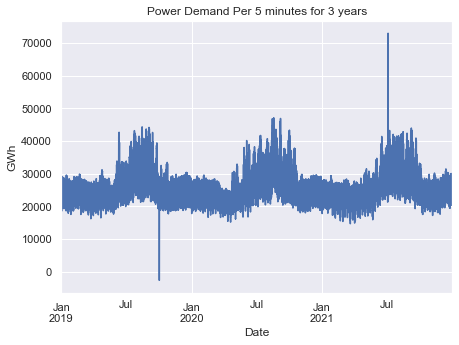

In [420]:
# plot all data with respect to time
pyplot.rcParams['figure.figsize'] = [7, 5]
demands['Current demand'].plot(xlabel='Date', ylabel='GWh', title = 'Power Demand Per 5 minutes for 3 years')
pyplot.show()

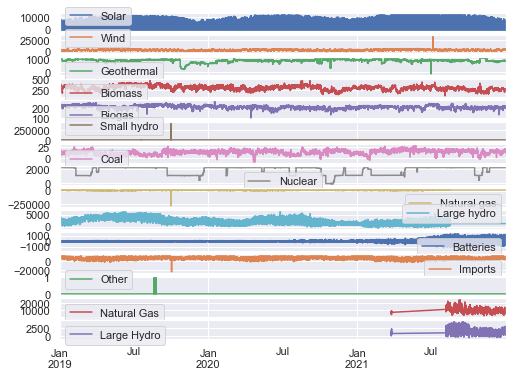

In [423]:
pyplot.rcParams['figure.figsize'] = [8, 6]
sources.plot(subplots=True)
pyplot.show()

## Rolling Mean & Std 

In [421]:
# Rolling mean and std for demand with a window of a day
demands_rolmean = demands['Current demand'].rolling(window=289).mean()
demands_rolstd = demands['Current demand'].rolling(window=289).std()

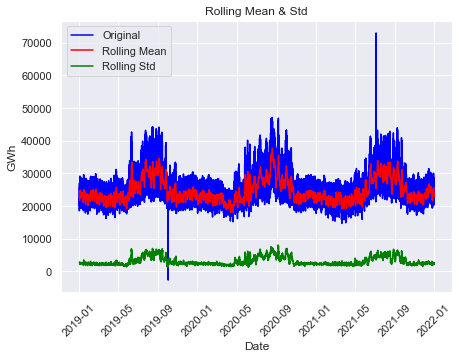

In [422]:
pyplot.title('Rolling Mean & Std')
pyplot.xlabel('Date')
pyplot.ylabel('GWh')
pyplot.plot(demands['Current demand'], color='blue', label='Original')
pyplot.plot(demands_rolmean, color='red', label='Rolling Mean')
pyplot.plot(demands_rolstd, color='green', label='Rolling Std')
pyplot.legend(loc='best')
pyplot.xticks(rotation=45)
pyplot.show()

## Basic Statistics

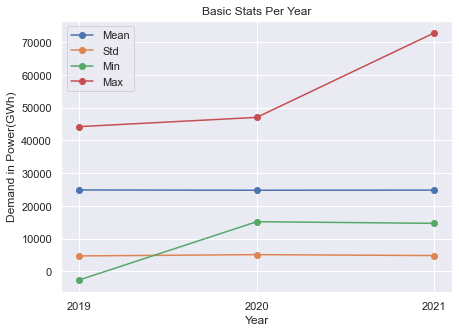

In [390]:
# calc mean, std, min, max per year
means = demands.groupby(by=demands.index.year).mean()['Current demand']
stds = demands.groupby(by=demands.index.year).std()['Current demand']
mins = demands.groupby(by=demands.index.year).min()['Current demand']
maxs = demands.groupby(by=demands.index.year).max()['Current demand']

basic_stats_year = pd.concat([means, stds, mins, maxs], axis=1, keys=['Mean', 'Std', 'Min', 'Max'])
basic_stats_year.plot(xlabel='Year', ylabel='Demand in Power(GWh)', title='Basic Stats Per Year', marker='o')
pyplot.xticks(demands.index.year.unique().values)
pyplot.show()

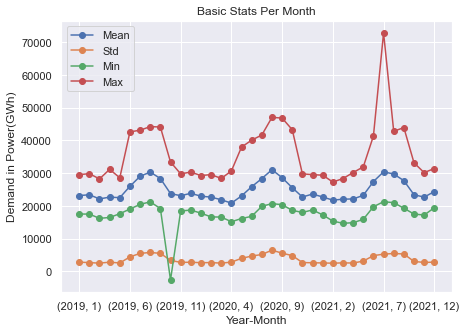

In [391]:
# calc mean, std, min, max per month
means = demands.groupby(by=[demands.index.year, demands.index.month]).mean()['Current demand']
stds = demands.groupby(by=[demands.index.year, demands.index.month]).std()['Current demand']
mins = demands.groupby(by=[demands.index.year, demands.index.month]).min()['Current demand']
maxs = demands.groupby(by=[demands.index.year, demands.index.month]).max()['Current demand']

basic_stats_year_month = pd.concat([means, stds, mins, maxs], axis=1, keys=['Mean', 'Std', 'Min', 'Max'])
basic_stats_year_month.plot(xlabel='Year-Month', ylabel='Demand in Power(GWh)', title='Basic Stats Per Month', marker='o')
pyplot.show()

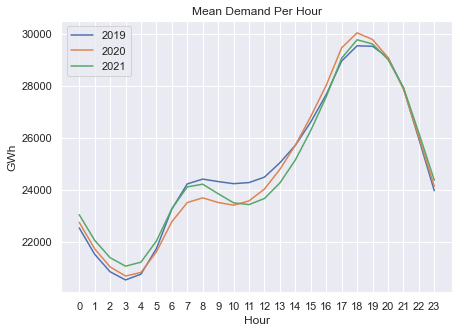

In [392]:
average_hour_per_year = demands.groupby(by=[demands.index.year, demands.index.hour]).mean()
pyplot.title('Mean Demand Per Hour')
pyplot.xlabel('Hour')
pyplot.ylabel('GWh')
pyplot.plot(average_hour_per_year[:24]['Current demand'].values, label='2019')
pyplot.plot(average_hour_per_year[24:48]['Current demand'].values, label='2020')
pyplot.plot(average_hour_per_year[48:]['Current demand'].values, label='2021')
pyplot.legend(loc='best')
pyplot.xticks(demands.index.hour.unique().values)
pyplot.show()

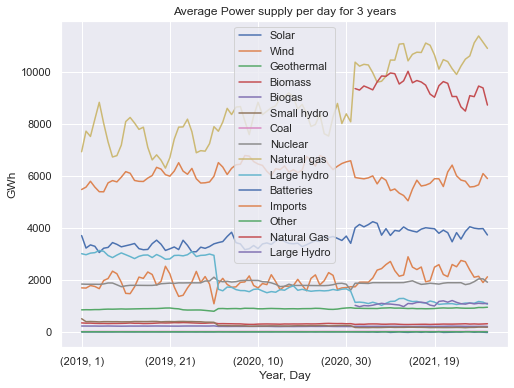

In [426]:
sources_day = sources.groupby(by=[sources.index.year, sources.index.day]).mean()
sources_day.plot(xlabel='Year, Day', ylabel='GWh', title='Average Power supply per day for 3 years')
pyplot.show()

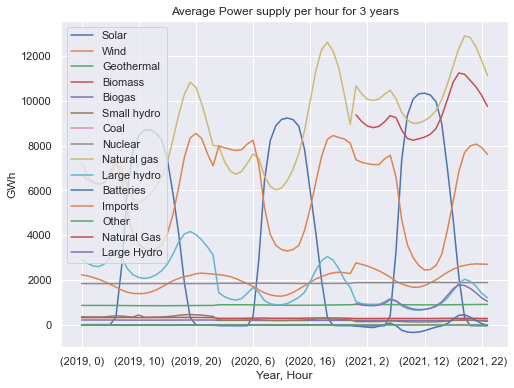

In [427]:
sources_hour = sources.groupby(by=[sources.index.year, sources.index.hour]).mean()
sources_hour.plot(xlabel='Year, Hour', ylabel='GWh', title='Average Power supply per hour for 3 years')
pyplot.show()

## Seasonality Plot

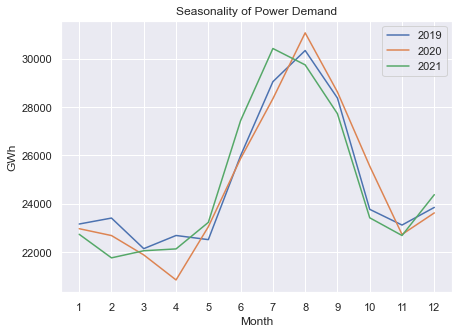

In [393]:
average_month_per_year = demands.groupby(by=[demands.index.year, demands.index.month]).mean()
pyplot.title('Seasonality of Power Demand')
pyplot.xlabel('Month')
pyplot.ylabel('GWh')
pyplot.plot(demands.index.month.unique().values, average_month_per_year[:12]['Current demand'].values, label='2019')
pyplot.plot(demands.index.month.unique().values, average_month_per_year[12:24]['Current demand'].values, label='2020')
pyplot.plot(demands.index.month.unique().values, average_month_per_year[24:]['Current demand'].values, label='2021')
pyplot.xticks(demands.index.month.unique().values)
pyplot.legend(loc='best')
pyplot.show()

## Stationarity Check

In [394]:
### check for stationarity
from statsmodels.tsa.stattools import adfuller, kpss

# ADF Test
result = adfuller(demands['Current demand'].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(demands['Current demand'].values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

"\n### check for stationarity\nfrom statsmodels.tsa.stattools import adfuller, kpss\n\n# ADF Test\nresult = adfuller(demands['Current demand'].values, autolag='AIC')\nprint(f'ADF Statistic: {result[0]}')\nprint(f'p-value: {result[1]}')\nfor key, value in result[4].items():\n    print('Critial Values:')\n    print(f'   {key}, {value}')\n\n# KPSS Test\nresult = kpss(demands['Current demand'].values, regression='c')\nprint('\nKPSS Statistic: %f' % result[0])\nprint('p-value: %f' % result[1])\nfor key, value in result[3].items():\n    print('Critial Values:')\n    print(f'   {key}, {value}')\n"

# Data clustering

## Data preparation

In [542]:
# Each row is now a time series
demands_analysis = pd.DataFrame(demands['Current demand'])
demands_analysis['Time'] = demands.index.time
demands_analysis.index = demands_analysis.index.date
demands_analysis = demands_analysis.pivot_table('Current demand', [demands_analysis.index], 'Time')

In [543]:
demands_analysis.head()

Time,00:00:00,00:05:00,00:10:00,00:15:00,00:20:00,00:25:00,00:30:00,00:35:00,00:40:00,00:45:00,...,23:10:00,23:15:00,23:20:00,23:25:00,23:30:00,23:35:00,23:40:00,23:45:00,23:50:00,23:55:00
2019-01-01,22216.0,22106.0,22130.0,22040.0,21963.0,21867.0,21792.0,21731.0,21666.0,21624.0,...,22790.0,22647.0,22562.0,22413.0,22302.0,22189.0,22096.0,21961.0,21838.0,21716.0
2019-01-02,21602.0,21521.0,21515.0,21452.0,21337.0,21264.0,21161.0,21100.0,21041.0,20969.0,...,24461.0,24306.0,24139.0,23994.0,23861.0,23731.0,23612.0,23452.0,23353.0,23199.0
2019-01-03,23047.0,22984.0,22945.0,22809.0,22720.0,22652.0,22532.0,22414.0,22320.0,22285.0,...,24138.0,23974.0,23838.0,23707.0,23490.0,23362.0,23257.0,23129.0,23030.0,22910.0
2019-01-04,22806.0,22723.0,22727.0,22681.0,22619.0,22542.0,22431.0,22297.0,22211.0,22158.0,...,23653.0,23518.0,23403.0,23291.0,23161.0,23006.0,22883.0,22751.0,22619.0,22532.0
2019-01-05,22369.0,22271.0,22319.0,22242.0,22151.0,22070.0,21983.0,21883.0,21790.0,21680.0,...,22906.0,22762.0,22632.0,22538.0,22425.0,22322.0,22195.0,22096.0,21973.0,21841.0


## Power Demand of 20 random days

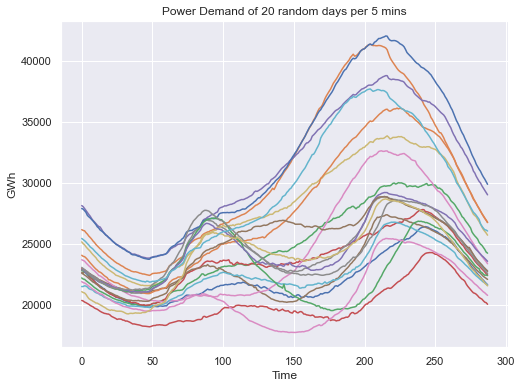

In [544]:
from random import randrange
rands = [randrange(demands_analysis.shape[0]) for _ in range(20)]
for i in rands:
    pyplot.plot(demands_analysis.iloc[i, :].values)
pyplot.title('Power Demand of 20 random days per 5 mins')
pyplot.ylabel('GWh')
pyplot.xlabel('Time')
pyplot.show()

## Standardization Data

In [545]:
import warnings
warnings.filterwarnings('ignore')

scaler = StandardScaler()
matrix = pd.DataFrame(scaler.fit_transform(demands_analysis), columns=demands_analysis.columns)
matrix.index = demands_analysis.index
matrix.head()

Time,00:00:00,00:05:00,00:10:00,00:15:00,00:20:00,00:25:00,00:30:00,00:35:00,00:40:00,00:45:00,...,23:10:00,23:15:00,23:20:00,23:25:00,23:30:00,23:35:00,23:40:00,23:45:00,23:50:00,23:55:00
2019-01-01,-0.370054,-0.389920,-0.367174,-0.367775,-0.363610,-0.364247,-0.357731,-0.347755,-0.340706,-0.322904,...,-0.590530,-0.594731,-0.581931,-0.590956,-0.587699,-0.585391,-0.575893,-0.584070,-0.587545,-0.591721
2019-01-02,-0.590835,-0.602579,-0.593053,-0.586228,-0.598762,-0.593291,-0.600093,-0.593023,-0.586492,-0.583495,...,-0.060976,-0.062549,-0.069493,-0.071204,-0.069141,-0.065665,-0.058309,-0.068742,-0.056968,-0.065508
2019-01-03,-0.071245,-0.070751,-0.067838,-0.082076,-0.079249,-0.066073,-0.073503,-0.082274,-0.083516,-0.059927,...,-0.163337,-0.169049,-0.167301,-0.165555,-0.192544,-0.190035,-0.179511,-0.180379,-0.170087,-0.168054
2019-01-04,-0.157904,-0.165630,-0.147906,-0.129630,-0.117189,-0.107855,-0.112297,-0.127752,-0.126381,-0.110453,...,-0.317038,-0.315327,-0.308652,-0.302315,-0.301977,-0.310024,-0.307200,-0.311026,-0.314026,-0.302180
2019-01-05,-0.315039,-0.329940,-0.297758,-0.292728,-0.292990,-0.287140,-0.284370,-0.288673,-0.291942,-0.300625,...,-0.553769,-0.557841,-0.559184,-0.549863,-0.546787,-0.540563,-0.542093,-0.537410,-0.540266,-0.547367


## Determining the number of cluster based on the Elbow Technique

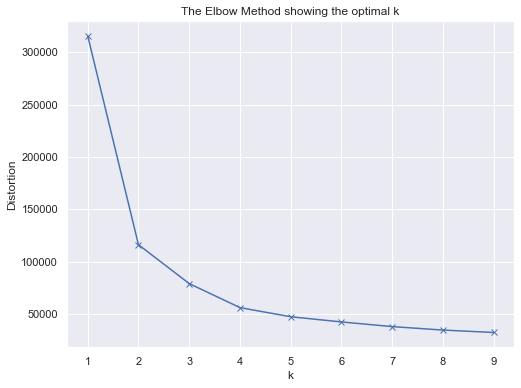

In [546]:
K = range(1,10)
distortions = []
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(matrix)
    distortions.append(kmeanModel.inertia_)
    
pyplot.figure(figsize=(8,6))
pyplot.plot(K, distortions, 'bx-')
pyplot.xlabel('k')
pyplot.ylabel('Distortion')
pyplot.title('The Elbow Method showing the optimal k')
pyplot.show()

In [547]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

cluster = KMeans(n_clusters=4, random_state=217)
matrix['cluster'] = cluster.fit_predict(matrix)
print(matrix['cluster'].value_counts())

0    500
2    255
1    217
3    124
Name: cluster, dtype: int64


Text(0.5, 1.0, 'Cluster of Data')

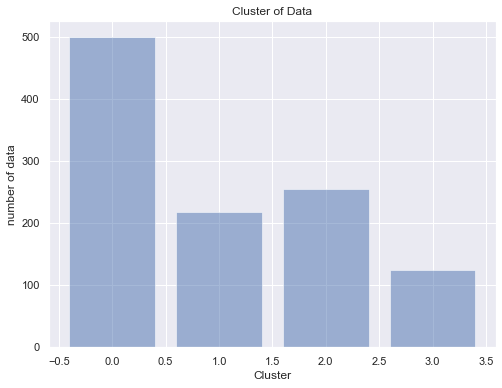

In [548]:
d = pd.DataFrame(matrix['cluster'].value_counts())
fig, ax = pyplot.subplots(figsize=(8, 6))
pyplot.bar(d.index, d['cluster'], align='center', alpha=0.5)
pyplot.xlabel('Cluster')
pyplot.ylabel('number of data')
pyplot.title('Cluster of Data')

In [549]:
cluster.cluster_centers_.shape

(4, 288)

In [550]:
from sklearn.metrics.pairwise import euclidean_distances

distance = euclidean_distances(cluster.cluster_centers_, cluster.cluster_centers_)
print(distance)

[[ 0.         18.57733182 13.97339644 37.41655161]
 [18.57733182  0.         29.62413193 19.59774124]
 [13.97339644 29.62413193  0.         49.19468293]
 [37.41655161 19.59774124 49.19468293  0.        ]]


In [551]:
pca = PCA(n_components=3)
x_calls = matrix.columns[:-1]
matrix['x'] = pca.fit_transform(matrix[x_calls])[:,0]
matrix['y'] = pca.fit_transform(matrix[x_calls])[:,1]
matrix['z'] = pca.fit_transform(matrix[x_calls])[:,2]

In [552]:
cluster_centers = pca.transform(cluster.cluster_centers_)
cluster_centers = pd.DataFrame(cluster_centers, columns=['x', 'y', 'z'])
cluster_centers['cluster'] = range(0, len(cluster_centers))
print(cluster_centers)

           x         y         z  cluster
0  -4.919655 -3.319985 -0.000429        0
1  12.720045  2.494246  0.273354        1
2 -16.858863  3.912783 -0.221314        2
3  32.246675  0.975657 -0.021517        3


Text(0.5, 1.0, 'Data Segmentation')

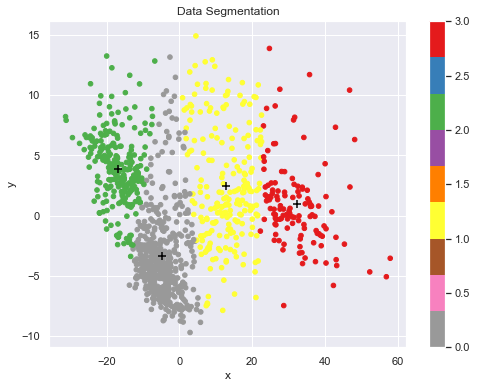

In [553]:
# Plotting for 2-dimention
fig, ax = pyplot.subplots(figsize=(8, 6))
scatter=ax.scatter(matrix['x'], matrix['y'], c=matrix['cluster'], s=21, cmap=pyplot.cm.Set1_r)
ax.scatter(cluster_centers['x'], cluster_centers['y'], s=70, c='black', marker='+')
ax.set_xlabel('x')
ax.set_ylabel('y')
pyplot.colorbar(scatter)
pyplot.title('Data Segmentation')

Text(0.5, 0.92, 'Data Segmentation')

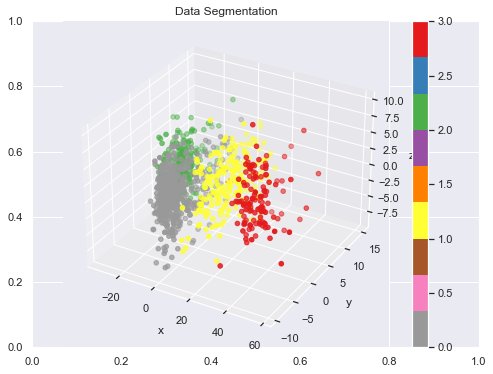

In [554]:
# Plotting for 3-Dimention
fig, ax = pyplot.subplots(figsize=(8, 6))
ax=fig.add_subplot(111, projection='3d')
scatter=ax.scatter(matrix['x'],matrix['y'],matrix['z'],c=matrix['cluster'],s=21,cmap=pyplot.cm.Set1_r)
ax.scatter(cluster_centers['x'],cluster_centers['y'],cluster_centers['z'],s=70,c='red',marker='+')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
pyplot.colorbar(scatter)
pyplot.title('Data Segmentation')